In [117]:
import os
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, List, Optional
from pre_process_data import PreProcessData
from datasets import CTPatchDataset

In [118]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt

In [119]:
# Since dataset and labels are already split between Experiment 1 and Experiment 2
# Maybe we just use Experiment 1 as our training data, and Experiment 2 as our testing data?
# Later we can change it (maybe combine them and do a random split/shuffle?)

@dataclass
class Config:
    # Paths to experiments
    exp1_path = Path("data/Experiment 1 - Blind/")
    exp2_path = Path("data/Experiment 2 - Open/")
    
    # Each row contains (uuid, slice, x, y)
    exp1_labels_csv = Path("data/labels_exp1.csv")
    exp2_labels_csv = Path("data/labels_exp2.csv")

    # Contains folders: <uuid>/volume.npz
    exp1_export_root = Path("data/export_exp1/")
    exp2_export_root = Path("data/export_exp2/")

    # So we don't hardcode "volume" everywhere
    volume_key = "volume"

    # Patch/Window around (x, y) from labels csv to feed into CNN
    patch_size = 128

    # Randomly shift crop center by this many pixels during training
    jitter_px = 6

    # Master switch for augmentations (jitter, flips, etc.)
    augment = True

    # Seed to keep random consistency
    seed = 6767

    # Training Parameters
    batch_size = 16
    epochs = 150
    lr = 0.001
    weight_decay = 0.0001
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # If classes are very imbalanced, sampler helps.
    use_weighted_sampler = True

CFG = Config()

In [120]:
# Seed our stuff
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)

In [121]:
# Preprocess our dataset
print(f"Preprocessing data...\n")

# Process Experiment 1 - Blind
if not CFG.exp1_export_root.exists():
    print(f"\t{CFG.exp1_export_root} does not yet exist.")
    print(f"\tProcessing {CFG.exp1_path}...")
    
    data_pre_processor = PreProcessData(CFG.exp1_path, CFG.exp1_export_root)
    data_pre_processor.run()
    
    print(f"\t{CFG.exp1_path} processed! {CFG.exp1_export_root} has been created!\n")
else:
    print(f"\t{CFG.exp1_export_root} already exists.\n")

# Process Experiment 2 - Open
if not CFG.exp2_export_root.exists():
    print(f"\t{CFG.exp2_export_root} does not yet exist.")
    print(f"\tProcessing {CFG.exp2_path}...")
    
    data_pre_processor = PreProcessData(CFG.exp2_path, CFG.exp2_export_root)
    data_pre_processor.run()
    
    print(f"\t{CFG.exp2_path} processed! {CFG.exp2_export_root} has been created!\n")
else:
    print(f"\t{CFG.exp2_export_root} already exists.\n")

print(f"Preprocessing finished!")

Preprocessing data...

	data/export_exp1 already exists.

	data/export_exp2 already exists.

Preprocessing finished!


In [122]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Assuming patch_size=128 then
        # Input (B, 1, 128, 128)

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # Output (B, 16, 128, 128)
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output (B, 16, 64, 64)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # Output (B, 32, 64, 64)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output (B, 32, 32, 32)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # Output (B, 64, 32, 32)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # Output (B, 64, 1, 1) then must flatten to (B, 64)
        self.fc1 = nn.Linear(in_features=64, out_features=4) # Output (B, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, 128, 128)
        x = self.block1(x)         # (B, 16, 64, 64)
        x = self.block2(x)         # (B, 32, 32, 32)
        x = self.block3(x)         # (B, 64, 32, 32)
        x = self.gap(x)            # (B, 64, 1, 1)
        x = torch.flatten(x, 1)    # (B, 64)
        x = self.fc1(x)            # (B, 4)
        
        return x    

In [123]:
# Sanity Check
model = CNN()
dummy = torch.randn(16, 1, 128, 128)
out = model(dummy)
print(out.shape) # Should print dimensions (16, 4)

torch.Size([16, 4])


In [124]:
# Create Datasets
# For now well train on Experiment 1 and test on Experiment 1
train_ds = CTPatchDataset(CFG.exp1_export_root, CFG.exp1_labels_csv, CFG.patch_size, CFG.augment, CFG.jitter_px)
test_ds = CTPatchDataset(CFG.exp2_export_root, CFG.exp2_labels_csv, CFG.patch_size, CFG.augment, CFG.jitter_px)

# Santiy check CTPatchDataset
x, y = ds[0]
print(x.shape, x.dtype, y, y.dtype) # Should output (1, patch_size, patch_size), torch.float32, tensor(0), and torch.int64

torch.Size([1, 128, 128]) torch.float32 tensor(0) torch.int64


In [125]:
# Create DataLoaders
# For now well train on Experiment 1 and test on Experiment 1
train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=0)

# Sanity check DataLoader
xb, yb = next(iter(train_loader))
print(xb.shape, xb.dtype, yb.shape, yb.dtype) # Should output(16, 1, patch_size, patch_size), torch.float32, (16,), and torch.int64

torch.Size([16, 1, 128, 128]) torch.float32 torch.Size([16]) torch.int64


In [126]:
# Initialize our model
model = CNN()
model.to(CFG.device)

# 4 classes, use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# NOTE: Hypertune optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

In [127]:
# Train our model
# this shits cooked bruh (expected tho)
logged_epochs = list()
losses = list()
validation_acc = list()
for epoch in range(CFG.epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(CFG.device)        # (B,1,128,128)
        yb = yb.to(CFG.device)        # (B,)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)        # (B,4)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(CFG.device)
            yb = yb.to(CFG.device)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()

    val_acc = correct / total
    if (epoch+1)%(CFG.epochs/25) == 0:
        print(f"epoch={epoch+1} train_loss={train_loss:.4f} val_acc={val_acc:.3f}")
        logged_epochs.append(epoch+1)
        losses.append(train_loss)
        validation_acc.append(val_acc)

epoch=6 train_loss=0.8187 val_acc=0.444
epoch=12 train_loss=0.7576 val_acc=0.389
epoch=18 train_loss=0.6588 val_acc=0.389
epoch=24 train_loss=0.6173 val_acc=0.389
epoch=30 train_loss=0.6025 val_acc=0.389
epoch=36 train_loss=0.5591 val_acc=0.389
epoch=42 train_loss=0.5624 val_acc=0.417
epoch=48 train_loss=0.5400 val_acc=0.417
epoch=54 train_loss=0.5202 val_acc=0.361
epoch=60 train_loss=0.4389 val_acc=0.528
epoch=66 train_loss=0.4809 val_acc=0.417
epoch=72 train_loss=0.4337 val_acc=0.389
epoch=78 train_loss=0.4237 val_acc=0.472
epoch=84 train_loss=0.4057 val_acc=0.333
epoch=90 train_loss=0.3912 val_acc=0.361
epoch=96 train_loss=0.4631 val_acc=0.444
epoch=102 train_loss=0.3601 val_acc=0.417
epoch=108 train_loss=0.3414 val_acc=0.361
epoch=114 train_loss=0.3530 val_acc=0.361
epoch=120 train_loss=0.3451 val_acc=0.500
epoch=126 train_loss=0.3304 val_acc=0.389
epoch=132 train_loss=0.3348 val_acc=0.333
epoch=138 train_loss=0.3223 val_acc=0.361
epoch=144 train_loss=0.2878 val_acc=0.389
epoch=150

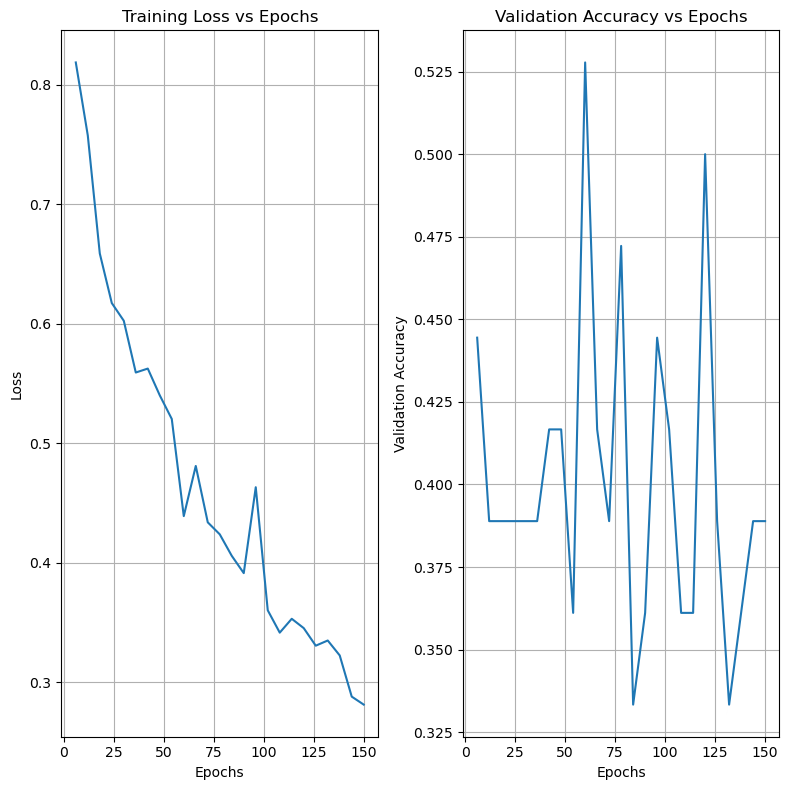

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.plot(logged_epochs, losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss vs Epochs')
ax1.grid(True)

ax2.plot(logged_epochs, validation_acc)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy vs Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [129]:
# this overfitting hella ngl
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(CFG.device)
        yb = yb.to(CFG.device)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

val_acc = correct / total
print(f"Accuracy on Test Dataset: {val_acc:.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(CFG.device)
        yb = yb.to(CFG.device)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

val_acc = correct / total
print(f"Accuracy on Train Dataset: {val_acc:.4f}")

Accuracy on Test Dataset: 0.3611
Accuracy on Train Dataset: 0.9173
